#  Классификация изображений с помощью сверточных нейронных сетей

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы:
* Deep Learning with PyTorch (2020) Авторы: Eli Stevens, Luca Antiga, Thomas Viehmann
* https://pytorch.org/docs/stable/nn.html#convolution-layers
* https://pytorch.org/vision/0.16/transforms.html#v2-api-reference-recommended
* https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
* https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html
* https://kozodoi.me/blog/20210308/compute-image-stats
* https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.matshow.html

In [ ]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import random

## Задачи для совместного разбора

1\. Рассмотрите основные возможности по созданию датасетов из `torchvision` и примеры работы основных слоев для создания сверточных нейронных сетей для анализа изображений.

2\. Реализуйте типовую архитектуру CNN для классификации изображений.

## Задачи для самостоятельного решения

<p class="task" id="1"></p>

### 1\. Создайте датасет `CatBreeds` на основе данных из архива `cat_breeds_4.zip`. Используя преобразования `torchvision`, приведите картинки к размеру 300х300 и нормализуйте значения интенсивности пикселей (рассчитайте статистику для нормализации отдельно). Выведите на экран количество картинок в датасете,  размер одной картинки, количество уникальных классов. Разбейте датасет на обучающее и тестовое множество в соотношении 80 на 20%.

- [ ] Проверено на семинаре

In [ ]:
data_dir = '/kaggle/input/cat-breeds-4/cat_breeds_4'

In [ ]:
initial_transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor()
])

In [ ]:
dataset = datasets.ImageFolder(root=data_dir, transform=initial_transform)

loader = DataLoader(dataset, batch_size=64, shuffle=False)
mean = 0.0
std = 0.0
for images, _ in loader:
    mean += images.mean([0, 2, 3])
    std += images.std([0, 2, 3])
mean /= len(loader)
std /= len(loader)

In [ ]:
transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

In [ ]:
mean, std

(tensor([0.5000, 0.4514, 0.4065]), tensor([0.2633, 0.2575, 0.2564]))

In [ ]:
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [ ]:
print(f'Количество картинок в датасете: {len(dataset)}')

Количество картинок в датасете: 4000


In [ ]:
print(f'Размер одной картинки: {dataset[0][0].shape}')

Размер одной картинки: torch.Size([3, 300, 300])


In [ ]:
print(f'Количество уникальных классов: {len(dataset.classes)}')

Количество уникальных классов: 4


<p class="task" id="2"></p>

### 2\. Решите задачу классификации на основе датасета из предыдущего задания, не используя сверточные слои. Постройте график изменения значения функции потерь на обучающем множестве в зависимости от номера эпохи, графики изменения метрики accuracy на обучающем и тестовом множестве в зависимости от эпохи. Выведите на экран итоговое значение метрики accuracy на обучающем и тестовом множестве. Выведите на экран количество параметров модели.   

- [ ] Проверено на семинаре

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Разворачиваем тензор
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
input_size = 300 * 300 * 3  # Размер входного изображения
hidden_size = 512  # Размер скрытого слоя
num_classes = len(dataset.classes)  # Количество классов

model = SimpleNN(input_size, hidden_size, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
def calculate_accuracy(loader, model):
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    model.train()
    return correct / total

Обучение модели

In [ ]:
num_epochs = 20
train_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    epoch_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    train_losses.append(epoch_loss / len(train_loader))

    # Вычисляем accuracy на обучающем и тестовом множествах
    train_accuracy = calculate_accuracy(train_loader, model)
    test_accuracy = calculate_accuracy(test_loader, model)

    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}')


Epoch [1/20], Loss: 13.8430, Train Accuracy: 0.4378, Test Accuracy: 0.3425
Epoch [2/20], Loss: 1.9100, Train Accuracy: 0.6212, Test Accuracy: 0.3575
Epoch [3/20], Loss: 0.9712, Train Accuracy: 0.7325, Test Accuracy: 0.3563
Epoch [4/20], Loss: 0.7379, Train Accuracy: 0.8178, Test Accuracy: 0.3688
Epoch [5/20], Loss: 0.5653, Train Accuracy: 0.8628, Test Accuracy: 0.3713
Epoch [6/20], Loss: 0.4176, Train Accuracy: 0.9028, Test Accuracy: 0.3825
Epoch [7/20], Loss: 0.3782, Train Accuracy: 0.8644, Test Accuracy: 0.3800
Epoch [8/20], Loss: 0.4371, Train Accuracy: 0.8691, Test Accuracy: 0.3725
Epoch [9/20], Loss: 0.4258, Train Accuracy: 0.8838, Test Accuracy: 0.3925
Epoch [10/20], Loss: 0.4117, Train Accuracy: 0.9203, Test Accuracy: 0.3563
Epoch [11/20], Loss: 0.3598, Train Accuracy: 0.9122, Test Accuracy: 0.3663
Epoch [12/20], Loss: 0.3565, Train Accuracy: 0.9022, Test Accuracy: 0.3725
Epoch [13/20], Loss: 0.4058, Train Accuracy: 0.8909, Test Accuracy: 0.3825
Epoch [14/20], Loss: 0.4002, Trai

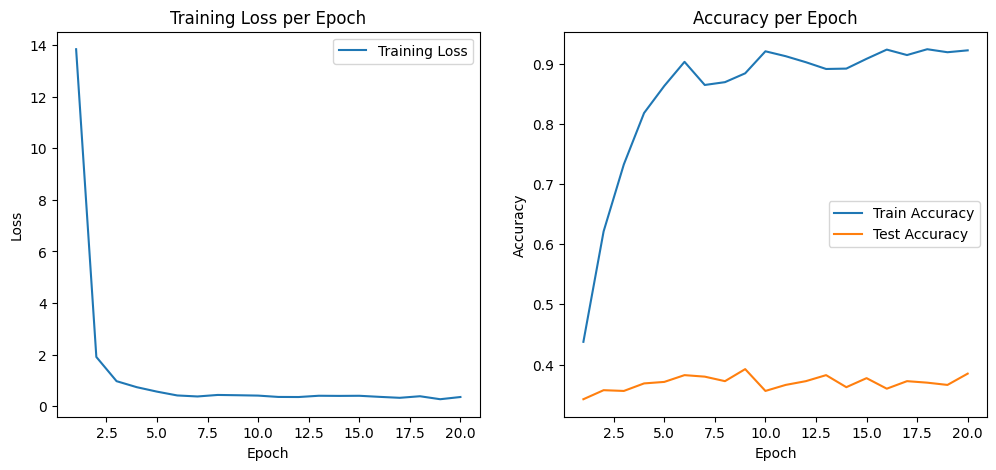

In [ ]:
plt.figure(figsize=(12, 5))

# График функции потерь
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch')
plt.legend()

# График accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs+1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy per Epoch')
plt.legend()

plt.show()

In [ ]:
# Итоговое значение accuracy на обучающем и тестовом наборах
final_train_accuracy = train_accuracies[-1]
final_test_accuracy = test_accuracies[-1]
print(f'Final Train Accuracy: {final_train_accuracy:.4f}')
print(f'Final Test Accuracy: {final_test_accuracy:.4f}')

Final Train Accuracy: 0.9219
Final Test Accuracy: 0.3850


In [ ]:
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Number of parameters in the model: {num_params}')

Number of parameters in the model: 138505220


Модель демонстрирует высокую точность на обучающем множестве, но низкую и нестабильную точность на тестовом. Это признаки переобучения — модель слишком хорошо подстраивается под обучающую выборку, но плохо обобщает на тестовые данные

Попробуем внести изменения, добавив Dropout и уменьшив размер скрытого слоя, и посмотреть, улучшатся ли результаты.

In [ ]:
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, dropout_rate=0.5):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size // 2)  # уменьшенный скрытый слой
        self.fc3 = nn.Linear(hidden_size // 2, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)  # Dropout слой

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Разворачиваем тензор
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

In [ ]:
input_size = 300 * 300 * 3  # Размер входного изображения
hidden_size = 512  # Размер скрытого слоя
num_classes = len(dataset.classes)  # Количество классов

model = SimpleNN(input_size, hidden_size, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
num_epochs = 20
train_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    epoch_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    train_losses.append(epoch_loss / len(train_loader))

    # Вычисляем accuracy на обучающем и тестовом множествах
    train_accuracy = calculate_accuracy(train_loader, model)
    test_accuracy = calculate_accuracy(test_loader, model)

    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}')

Epoch [1/20], Loss: 26.1457, Train Accuracy: 0.3756, Test Accuracy: 0.3187
Epoch [2/20], Loss: 3.5982, Train Accuracy: 0.2619, Test Accuracy: 0.2437
Epoch [3/20], Loss: 1.6280, Train Accuracy: 0.2666, Test Accuracy: 0.2487
Epoch [4/20], Loss: 1.4737, Train Accuracy: 0.2975, Test Accuracy: 0.2737
Epoch [5/20], Loss: 1.4468, Train Accuracy: 0.2959, Test Accuracy: 0.2725
Epoch [6/20], Loss: 1.4202, Train Accuracy: 0.3259, Test Accuracy: 0.3025
Epoch [7/20], Loss: 1.3944, Train Accuracy: 0.3234, Test Accuracy: 0.3113
Epoch [8/20], Loss: 1.3959, Train Accuracy: 0.3284, Test Accuracy: 0.3100
Epoch [9/20], Loss: 1.4183, Train Accuracy: 0.2966, Test Accuracy: 0.2725
Epoch [10/20], Loss: 1.3740, Train Accuracy: 0.3097, Test Accuracy: 0.2863
Epoch [11/20], Loss: 1.3787, Train Accuracy: 0.3131, Test Accuracy: 0.2938
Epoch [12/20], Loss: 1.3720, Train Accuracy: 0.3159, Test Accuracy: 0.2900
Epoch [13/20], Loss: 1.3790, Train Accuracy: 0.3003, Test Accuracy: 0.2762
Epoch [14/20], Loss: 1.3654, Trai

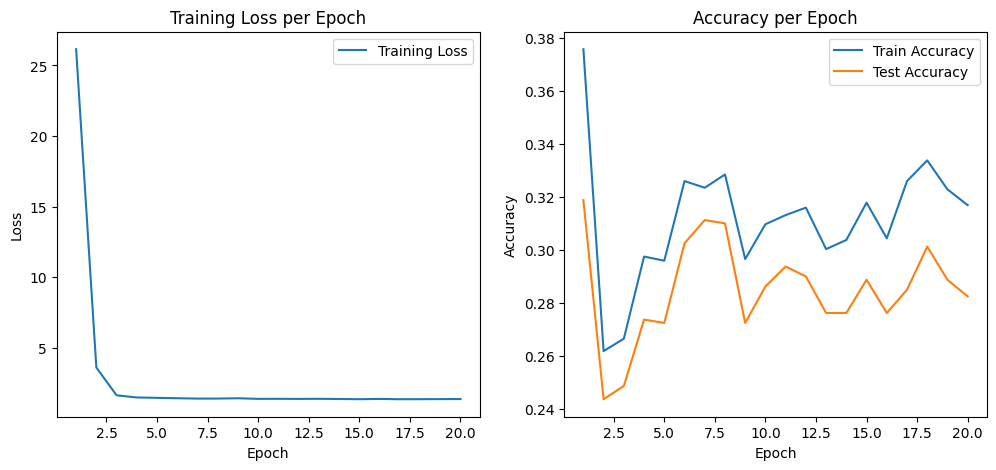

In [ ]:
plt.figure(figsize=(12, 5))

# График функции потерь
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch')
plt.legend()

# График accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs+1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy per Epoch')
plt.legend()

plt.show()

In [ ]:
final_train_accuracy = train_accuracies[-1]
final_test_accuracy = test_accuracies[-1]
print(f'Final Train Accuracy: {final_train_accuracy:.4f}')
print(f'Final Test Accuracy: {final_test_accuracy:.4f}')

Final Train Accuracy: 0.3169
Final Test Accuracy: 0.2825


In [ ]:
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Number of parameters in the model: {num_params}')

Number of parameters in the model: 138372868


<p class="task" id="3"></p>

### 3\. Напишите функцию, которая выбирает несколько изображений из переданного набора данных и выводит их на экран в виде сетки с указанием над ними названия правильного класса и класса, предсказанного моделью. Воспользовавшись данной функцией, выведите прогнозы итоговой модели из предыдущей задачи по 6 случайным картинкам.

```
def show_examples(model, dataset, k=6):
    pass
```

- [ ] Проверено на семинаре

In [ ]:
def show_examples(model, dataset, k=6):
    model.eval()  # Переключаем модель в режим оценки
    fig, axes = plt.subplots(1, k, figsize=(15, 5))

    # Получение mean и std из transforms.Normalize
    if hasattr(dataset, 'dataset') and hasattr(dataset.dataset, 'transform'):
        transform = dataset.dataset.transform
    elif hasattr(dataset, 'transform'):
        transform = dataset.transform
    else:
        transform = None
    mean, std = None, None
    if transform is not None:
        for t in transform.transforms:
            if isinstance(t, transforms.Normalize):
                mean, std = t.mean, t.std

    for i in range(k):
        idx = random.randint(0, len(dataset) - 1)
        image, true_label = dataset[idx]
        image_tensor = image.unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(image_tensor)
            _, predicted_label = torch.max(output, 1)

        # Перевод тензора изображения в numpy для отображения
        image = image.permute(1, 2, 0).cpu().numpy()  # (C, H, W) -> (H, W, C)
        if mean is not None and std is not None:
            image = np.clip(image * np.array(std) + np.array(mean), 0, 1)  # денормализация

        # Отображение
        axes[i].imshow(image)
        axes[i].set_title(f'True: {dataset.dataset.classes[true_label]}\nPred: {dataset.dataset.classes[predicted_label.item()]}')
        axes[i].axis('off')

    plt.show()
    model.train()


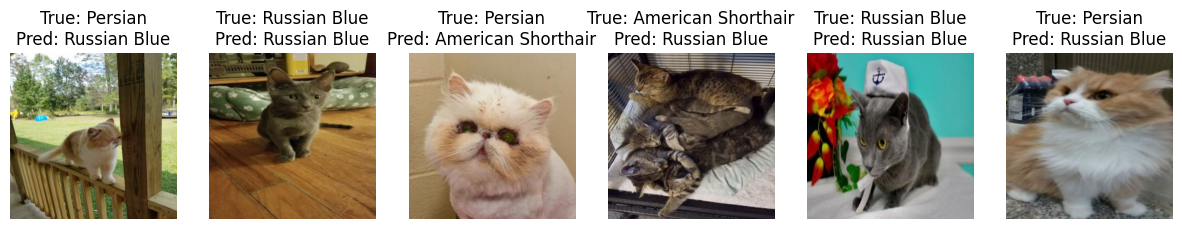

In [ ]:
show_examples(model, test_dataset)

<p class="task" id="4"></p>

### 4\. Решите задачу классификации на основе датасета из первого задания, используя сверточные слои. Постройте график изменения значения функции потерь на обучающем множестве в зависимости от номера эпохи, графики изменения метрики accuracy на обучающем и тестовом множестве в зависимости от эпохи. Выведите на экран итоговое значение метрики accuracy на обучающем и тестовом множестве. Выведите на экран количество параметров модели. Воспользовавшись функцией из предыдущего задания, выведите прогнозы итоговой модели по 6 случайным картинкам.

- [ ] Проверено на семинаре

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 75 * 75, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 75 * 75)  # Flatten для fully connected слоев
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

In [ ]:
model_cnn = SimpleCNN(num_classes=len(train_dataset.dataset.classes)).to(device)

def count_parameters(model):
    return sum(p.numel() for p in model_cnn.parameters() if p.requires_grad)

print(f"Количество параметров модели: {count_parameters(model)}")

Количество параметров модели: 46100036


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_cnn.parameters(), lr=0.0001)

num_epochs = 20
train_loss_history, train_acc_history, test_acc_history = [], [], []

In [ ]:
for epoch in range(num_epochs):
    model_cnn.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model_cnn(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader.dataset)
    train_acc = correct / total
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)

    model_cnn.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model_cnn(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    test_acc = correct / total
    test_acc_history.append(test_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, "
          f"Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}")

Epoch [1/20], Loss: 1.4226, Train Accuracy: 0.3381, Test Accuracy: 0.3550
Epoch [2/20], Loss: 1.2751, Train Accuracy: 0.3962, Test Accuracy: 0.4650
Epoch [3/20], Loss: 1.2215, Train Accuracy: 0.4522, Test Accuracy: 0.4875
Epoch [4/20], Loss: 1.1636, Train Accuracy: 0.4863, Test Accuracy: 0.5150
Epoch [5/20], Loss: 1.0908, Train Accuracy: 0.5375, Test Accuracy: 0.5275
Epoch [6/20], Loss: 1.0257, Train Accuracy: 0.5697, Test Accuracy: 0.4863
Epoch [7/20], Loss: 0.9512, Train Accuracy: 0.6122, Test Accuracy: 0.5312
Epoch [8/20], Loss: 0.8507, Train Accuracy: 0.6681, Test Accuracy: 0.5350
Epoch [9/20], Loss: 0.7752, Train Accuracy: 0.7019, Test Accuracy: 0.5537
Epoch [10/20], Loss: 0.7005, Train Accuracy: 0.7362, Test Accuracy: 0.5475
Epoch [11/20], Loss: 0.6118, Train Accuracy: 0.7841, Test Accuracy: 0.5450
Epoch [12/20], Loss: 0.5664, Train Accuracy: 0.7969, Test Accuracy: 0.5550
Epoch [13/20], Loss: 0.4829, Train Accuracy: 0.8350, Test Accuracy: 0.5363
Epoch [14/20], Loss: 0.4312, Train

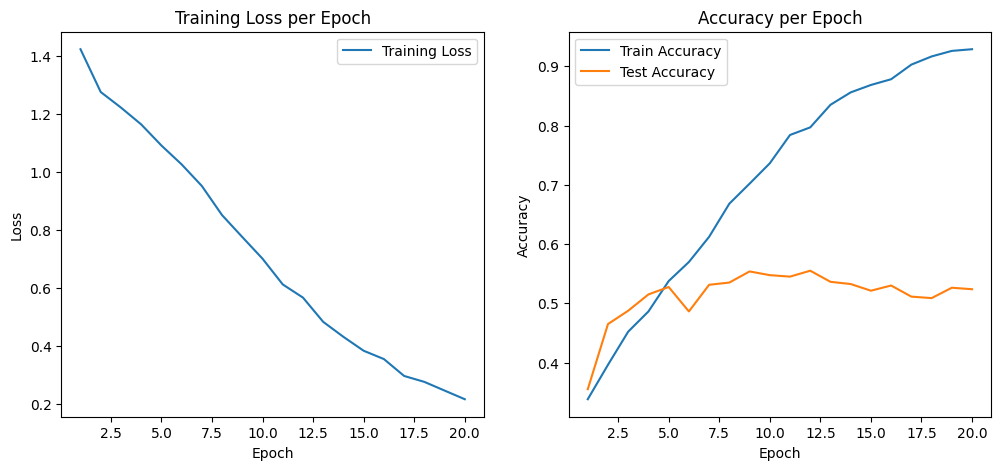

In [ ]:
plt.figure(figsize=(12, 5))

# График функции потерь
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_loss_history, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch')
plt.legend()

# График accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_acc_history, label='Train Accuracy')
plt.plot(range(1, num_epochs+1), test_acc_history, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy per Epoch')
plt.legend()

plt.show()

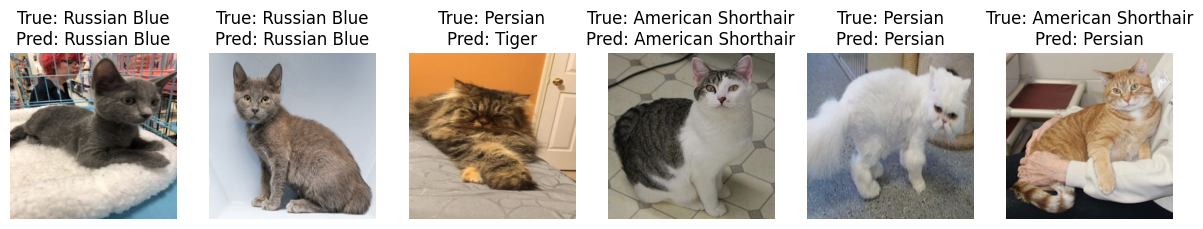

In [ ]:
show_examples(model_cnn, test_dataset)

In [ ]:
final_train_accuracy = train_acc_history[-1]
final_test_accuracy = test_acc_history[-1]
print(f'Final Train Accuracy: {final_train_accuracy:.4f}')
print(f'Final Test Accuracy: {final_test_accuracy:.4f}')

Final Train Accuracy: 0.9287
Final Test Accuracy: 0.5238


Несмотря на высокую точность на тренировочных данных, тестовая точность стабилизировалась на уровне около 50%. Это указывает на проблему с обобщающей способностью модели. Возможно, модель переобучается на тренировочные данные и недостаточно эффективно распознает новые образцы.

<p class="task" id="5"></p>

### 5\. Проанализируйте обученную в предыдущей задаче модель, исследовав обученные ядра сверточных слоев. Выберите одно изображение из тестового набора данных и пропустите через первый сверточный слой модели. Визуализируйте полученные карты признаков.

- [ ] Проверено на семинаре

In [ ]:
test_image, _ = test_dataset[0]
test_image = test_image.unsqueeze(0).to(device)

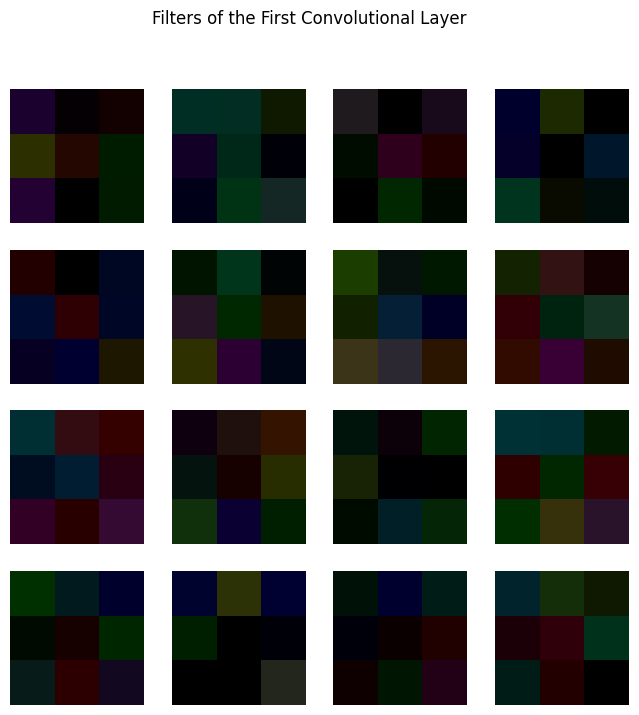

In [ ]:
first_conv_layer = model_cnn.conv1
with torch.no_grad():
    feature_maps = first_conv_layer(test_image)

filters = first_conv_layer.weight.data.cpu()
fig, axs = plt.subplots(4, 4, figsize=(8, 8))
fig.suptitle("Filters of the First Convolutional Layer")
for i, ax in enumerate(axs.flat):
    if i < filters.shape[0]:
        ax.imshow(filters[i].permute(1, 2, 0).squeeze(), cmap='gray')
        ax.axis('off')
plt.show()

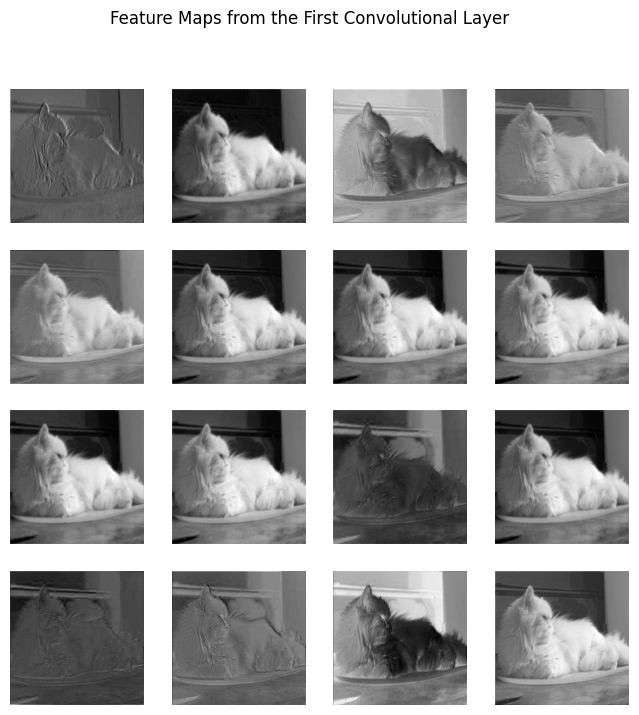

In [ ]:
fig, axs = plt.subplots(4, 4, figsize=(8, 8))
fig.suptitle("Feature Maps from the First Convolutional Layer")
for i, ax in enumerate(axs.flat):
    if i < feature_maps.shape[1]:
        ax.imshow(feature_maps[0, i].cpu().numpy(), cmap='gray')
        ax.axis('off')
plt.show()

Анализ карт признаков первого сверточного слоя показывает, что модель выделяет основные текстурные и контурные элементы на изображениях, такие как границы и формы. Это подтверждает, что начальные слои эффективно выполняют свою функцию по извлечению базовых признаков, необходимых для более глубоких уровней модели. Однако может быть недостаточно глубины модели, чтобы улавливать более сложные особенности, необходимые для лучшей обобщающей способности на тестовых данных.

## Заключение

### Модель достигла хороших результатов на тренировочном множестве, но имеет трудности с обобщением на тестовые данные. Это указывает на необходимость дальнейшего улучшения архитектуры и гиперпараметров, а также возможного расширения набора данных или использования более агрессивной аугментации.

## Обратная связь
- [ ] Хочу получить обратную связь по решению